In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table

from tqdm import tqdm
tqdm.pandas()

## Loading Data

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
orig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/data'
cosmos_folder = 'E:/cosmos-data'

In [3]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)
df_cat.head()

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [4]:
or_sample = pd.read_csv(f'{orig_folder}/interacting-catalogue.csv', index_col = 0)
or_sample.head()

,SourceID,RA,Dec,int_prediction,references,status
0,4000704963129,187.983807,58.010524,0.958096,No_entry,Unreferenced
1,4000704963271,187.980323,58.026481,0.966350,No_entry,Unreferenced
2,4000704963422,187.938181,58.039949,0.956150,No_entry,Unreferenced
3,4000705131622,217.216271,34.015278,0.987888,No_entry,Unreferenced
4,4000705131630,217.207839,34.015576,0.984174,No_entry,Unreferenced


## Getting IDs

In [5]:
df_cat_red = df_cat[['ORyanID_23','ID']].rename(columns = {'ORyanID_23' : 'SourceID', 'ID' : 'analysed-id'})
df_cat_red.head()

,SourceID,analysed-id
0,4000705532455,816891
1,4000705533383,860686
2,4000705539941,1301188
3,4000705540034,1304538
4,4000705540064,1310001


In [6]:
df_merge = df_cat_red.merge(or_sample[['SourceID', 'RA', 'Dec']], on = 'SourceID', how = 'left').dropna()
df_merge.head()

,SourceID,analysed-id,RA,Dec
0,4000705532455,816891,150.679664,2.196615
1,4000705533383,860686,150.645125,2.237650
2,4000705539941,1301188,149.702652,2.654624
3,4000705540034,1304538,149.727017,2.658066
4,4000705540064,1310001,149.701495,2.660271


## Importing FITS File

In [7]:
with fits.open(f'{cosmos_folder}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

## Searching

In [8]:
def get_cosmos_id(ra, dec, data):
    
    record = data[(data['ALPHA_J2000'] < (ra + (3 / 3600))) & (data['ALPHA_J2000'] > (ra - (3 / 3600))) & (data['DELTA_J2000'] < (dec + (3 / 3600))) & (data['DELTA_J2000'] > (dec - (3 / 3600)))]
    
    table = Table(record)
    
    df = table.to_pandas()[['ID','ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_type']]
    df = df.query('lp_type == 0').drop(columns = 'lp_type')
    
    if len(df) < 0.5:
        return 'null'
    
    df_sep = (
        df
        .assign(ang_sep = df.apply(lambda row: abs(SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'icrs').separation(SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')).to(u.arcsec)), axis = 1))
    )
        
    prim_id = df_sep.sort_values(by = 'ang_sep', ascending = True)
    
    prim_gal_id = prim_id['ang_sep'].iloc[0]
    
    return prim_gal_id.value

In [9]:
df_rest_ids = (
    df_merge
    .assign(restrict_id = df_merge.progress_apply(lambda row: get_cosmos_id(row.RA, row.Dec, data), axis = 1))
)

100%|██████████| 3072/3072 [54:37<00:00,  1.07s/it] 


In [31]:
df_types = (
    df_rest_ids
    .assign(types = df_rest_ids.restrict_id.apply(lambda x: str(type(x))))
)

In [34]:
numpy_type = str(type(df_rest_ids.restrict_id.iloc[0]))

In [35]:
seps = list(df_types.query('types == @numpy_type').restrict_id)

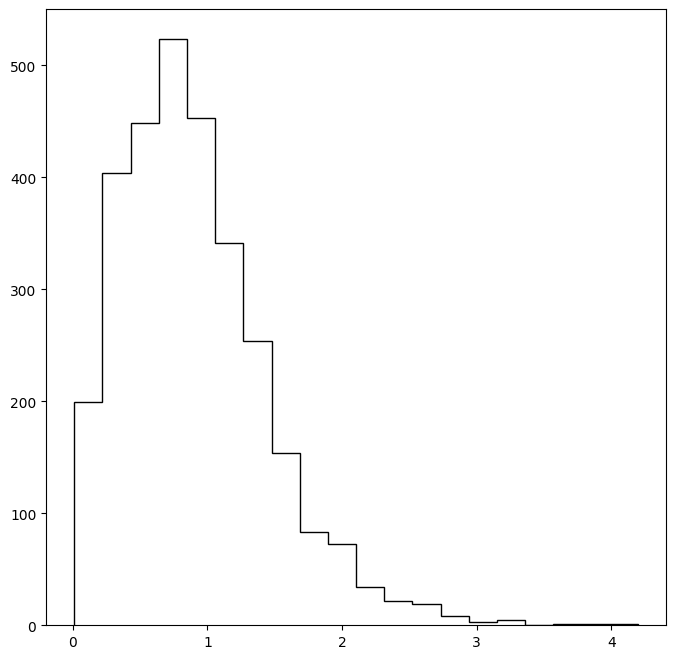

In [38]:
plt.figure(figsize = (8,8))
plt.hist(seps, bins = 20, color = 'black', histtype = 'step')
plt.show()

In [32]:
df_rename_ids = df_rest_ids.rename(columns = {'analysed-id' : 'analysed_id'})

In [34]:
print(len(df_rename_ids))
print(len(df_rename_ids.query('analysed_id != restrict_id')))
print(len(df_rename_ids.query('analysed_id != restrict_id')) / len(df_rest_ids))

3072
901
0.2932942708333333


In [39]:
df_matched = (
    df_rename_ids
    .assign(id_match = df_rename_ids.apply(lambda row: 'y' if row.analysed_id == row.restrict_id else 'n', axis = 1))
)
df_matched.head()

,SourceID,analysed_id,RA,Dec,restrict_id,id_match
0,4000705532455,816891,150.679664,2.196615,816891,y
1,4000705533383,860686,150.645125,2.237650,861738,n
2,4000705539941,1301188,149.702652,2.654624,1301188,y
3,4000705540034,1304538,149.727017,2.658066,1304538,y
4,4000705540064,1310001,149.701495,2.660271,1310001,y


In [48]:
len(df_matched)

3072

In [49]:
df_matched.drop_duplicates('SourceID', keep='first')

,SourceID,analysed_id,RA,Dec,restrict_id,id_match
0,4000705532455,816891,150.679664,2.196615,816891,y
1,4000705533383,860686,150.645125,2.237650,861738,n
2,4000705539941,1301188,149.702652,2.654624,1301188,y
3,4000705540034,1304538,149.727017,2.658066,1304538,y
4,4000705540064,1310001,149.701495,2.660271,1310001,y
...,...,...,...,...,...,...
2560,4001111524196,991056,150.406927,2.355820,988878,n
2561,4001185627710,1294479,149.997831,2.651329,1295082,n
2562,6000508613553,1140076,150.610729,2.494162,1140076,y
2563,6000518662663,575198,150.421572,1.985231,588501,n


In [40]:
df_vis_clsf = (
    pd.read_csv(f'{data_folder}/secondaries-identified.csv', index_col = 0)
    .reset_index()
    .rename(columns = {'index' : 'SourceID', '0' : 'vis_clsf'})
)
df_vis_clsf.head()

,SourceID,vis_clsf
0,4000705532455,n
1,4000705532984,nm
2,4000705533312,y
3,4000705533383,n
4,4000705539435,l


In [47]:
df_vis_clsf.vis_clsf.value_counts()

n      2186
y       755
nm      441
l       248
b       149
m         2
nn        1
nm.       1
nnm       1
n#        1
nbm       1
Name: vis_clsf, dtype: int64

In [42]:
df_matched_vis = df_matched.merge(df_vis_clsf, on = 'SourceID', how = 'left')

In [45]:
df_matched_vis.query('id_match == "n"').vis_clsf.value_counts()

n    532
y    211
b    158
Name: vis_clsf, dtype: int64